In [1]:
import os
import cv2

from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import math
import matplotlib.pyplot as plt

import numpy.matlib
from numpy.linalg import inv, det
import numpy as np

In [2]:
dir_path = "C:/Users/chinm/Documents/Courses/Sem4/CV/Project/1/"

images_dir = "data/originalPics/"
fddb_file_path = "data/FDDB-folds/"
img_format = ".jpg"

output_dir = "data/output/"
bbox_fdd_folds = "bbox-FDDB-folds/"
bbox_faces_dir = "faces/"
bbox_non_faces_dir = "non_faces/"
face_dim = (20, 20)

model_path = "models/"

In [3]:
no_of_components = 3
dimensions_after_pca = 100

In [4]:
def get_files(path):
    files = []
    for root, subdirs, images in os.walk(path):
        if images:
            full_path_images = [os.path.join(root, image).replace("\\", "/") for image in images]
            files.extend(full_path_images)
    return files

In [5]:
def data_preparation():
    face_files = get_files(dir_path + output_dir + bbox_faces_dir)
    non_face_files = get_files(dir_path + output_dir + bbox_non_faces_dir)
    
    tr_face_data_images = face_files[:1000] 
    tr_non_face_data_images = non_face_files[:1000]
    
    te_face_data_images = face_files[1000:1100] 
    te_non_face_data_images = non_face_files[1000:1100]
    
    tr_face_data = [cv2.imread(img) for img in tr_face_data_images]
    tr_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_face_data]
    tr_non_face_data = [cv2.imread(img) for img in tr_non_face_data_images]
    tr_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in tr_non_face_data]
    
    te_face_data = [cv2.imread(img) for img in te_face_data_images]
    te_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_face_data]
    
    te_non_face_data = [cv2.imread(img) for img in te_non_face_data_images]
    te_non_face_data = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64) for img in te_non_face_data]

    tr_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in tr_face_data])
    tr_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in tr_non_face_data])
    
    te_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in te_face_data])
    te_non_face_data = np.array([cv2.normalize(i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).flatten() for i in te_non_face_data])
    
    tr_face_labels = np.array([1]*1000)
    tr_non_face_labels = np.array([0]*1000)
    
    te_face_labels = np.array([1]*100)
    te_non_face_labels = np.array([0]*100)
    
    return tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, te_non_face_data, te_face_labels, te_non_face_labels

In [6]:
tr_face_data, tr_non_face_data, tr_face_labels, tr_non_face_labels, te_face_data, te_non_face_data, te_face_labels, te_non_face_labels = data_preparation()
len(tr_face_data), len(tr_non_face_data), len(tr_face_labels), len(tr_non_face_labels), len(te_face_data), len(te_non_face_data), len(te_face_labels), len(te_non_face_labels)

(1000, 1000, 1000, 1000, 100, 100, 100, 100)

In [7]:
def preprocessing(data):
    pca = PCA(n_components=100)
    pca.fit(data)
    pca_data = pca.transform(data)
    std_scaler = StandardScaler()
    std_scaler.fit(pca_data)
    std_data = std_scaler.transform(pca_data)
    return pca, std_data

In [8]:
pca_f, tr_f_data = preprocessing(tr_face_data)
pca_nf, tr_nf_data = preprocessing(tr_non_face_data)
_, te_f_data = preprocessing(te_face_data)
_, te_nf_data = preprocessing(te_non_face_data)

In [9]:
tr_f_data, tr_nf_data, te_f_data, te_nf_data = tr_f_data.T, tr_nf_data.T, te_f_data.T, te_nf_data.T

In [10]:
tr_f_data.shape, tr_nf_data.shape, te_f_data.shape, te_nf_data.shape

((100, 1000), (100, 1000), (100, 100), (100, 100))

In [11]:
class Mixture_of_Gaussian():
    def __init__(self, data_size, mean, covs, k, img_dim=(20,20)):
        self.data_size = data_size
        self.mean = mean
        self.covs = covs
        self.img_dim = img_dim
        
        self.storing_dir = "Mixture_of_Gaussian/"
        self.K = k
        
        self.lambda_ = np.random.dirichlet(np.ones(self.K), size = 1)[0]
        self.posterior = np.random.dirichlet(np.ones(self.K), size = self.data_size)
        
    def pdf(self, data, row, k):
        temp1 = np.matmul((data[:,row].reshape(-1,1)-self.mean[k]).T, inv(self.covs[k]))
        temp2 = -0.5*np.matmul(temp1, data[:,row].reshape(-1,1)-self.mean[k])
        pdf = np.exp(temp2)/(np.sqrt(det(self.covs[k]) * (2*np.pi**data.shape[0])))
        return pdf
                
    def fit(self, k, data):
        for i in range(self.data_size):
            self.EM(i, k, data)
            
    def EM(self, row, k, data):
        #E-step
        posterior_denom = 0
        for i in range(self.K):
            posterior_denom = posterior_denom + self.lambda_[i] * self.pdf(data, row, i)
        self.posterior[row, k] = self.lambda_[k] * self.pdf(data, row, k) / posterior_denom
        
        #update lambda
        numerator = 0
        denominator = 0
        for j in range(self.data_size):
            numerator += self.posterior[j,k]
            for i in range(self.K):
                denominator += self.posterior[j,i]
        self.lambda_[k] = 1.0*numerator/denominator
        
        #update mean
        numerator = np.zeros((self.mean.shape[1],1))
        denominator = 0
        for i in range(self.data_size):
            numerator += self.posterior[i,k] * data[:,i].reshape(-1,1)
            denominator += self.posterior[i,k]
        self.mean[k] = 1.0*numerator/denominator
        
        #update cov
        numerator = np.zeros((self.mean.shape[1],self.mean.shape[1]))
        denominator = 0
        for i in range(self.data_size):
            numerator += self.posterior[i,k] * \
            np.matmul( (data[:,i].reshape(-1,1)-self.mean[k]), (data[:,i].reshape(-1,1)-self.mean[k]).T)
            denominator += self.posterior[i,k]
        self.covs[k] = 1.0*numerator/denominator
        self.covs[k] = np.diag(np.diag(self.covs[k]))
    
    def predict(self, data, row):
        prob = 0
        for k in range(self.K):
            prob += self.lambda_[k] * self.pdf(data, row, k)
        return prob    

In [12]:
mean_f = np.zeros((no_of_components,100,1))
covs_f = np.array([np.random.uniform(low=0.0, high=1.0, size=(dimensions_after_pca,dimensions_after_pca)) \
                   * np.identity(100) for k in range(no_of_components)])
mog_f = Mixture_of_Gaussian(tr_f_data.shape[1], mean_f, covs_f, no_of_components)

In [13]:
iterations = 3
for k in range(iterations):
    print("Iteration {}".format(k))
    mog_f.fit(k,tr_f_data)
    print("Mixture of Gaussian-lambda values for face data-{}".format(mog_f.lambda_))

Iteration 0
Mixture of Gaussian-lambda values for face data-[0.6011674  0.79540882 0.13849017]
Iteration 1
Mixture of Gaussian-lambda values for face data-[0.6011674  0.17491844 0.13849017]
Iteration 2
Mixture of Gaussian-lambda values for face data-[0.6011674  0.17491844 0.14479558]


Mean Image: Face Component: 0


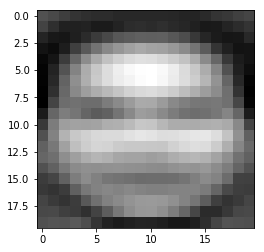

Cov Image: Face Component: 0


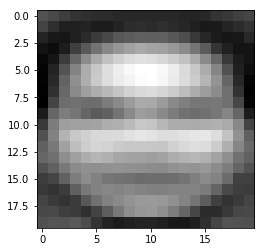

Mean Image: Face Component: 1


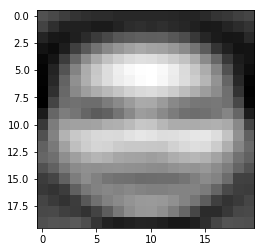

Cov Image: Face Component: 1


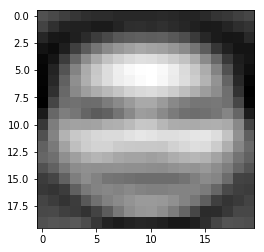

Mean Image: Face Component: 2


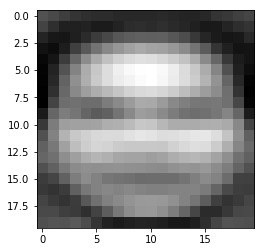

Cov Image: Face Component: 2


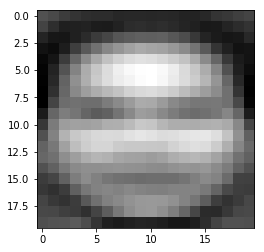

In [38]:
for k in range(no_of_components):
    mean_image = np.dot(mean_f[k][:,0], pca_f.components_) + pca_f.mean_
    mean_image = mean_image.reshape((20,20))
    
    cov_image = np.diagonal(mog_f.covs[k])
    cov_image = np.dot(np.log(cov_image), pca_f.components_) + pca_f.mean_
    cov_image = cov_image.reshape((20,20))
    
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Mean_Face_Image_{}.jpg".format(k), mean_image, cmap='gray')
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Cov_Face_Image_{}.jpg".format(k), cov_image, cmap='gray')    
    
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Mean_Face_Image_Resize_{}.jpg".format(k), \
                cv2.resize(mean_image, (60,60)), cmap='gray')
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Cov_Face_Image_Resize_{}.jpg".format(k), \
                cv2.resize(cov_image, (60,60)), cmap='gray')
    print("Mean Image: Face Component: {}".format(k))
    plt.imshow(mean_image, cmap="gray")
    plt.show()
    
    print("Cov Image: Face Component: {}".format(k))
    plt.imshow(cov_image, cmap="gray")
    plt.show()

In [15]:
mean_nf = np.zeros((no_of_components,100,1))
covs_nf = np.array([np.random.uniform(low=0.0, high=1.0, size=(dimensions_after_pca, dimensions_after_pca)) \
                    * np.identity(100) for k in range(no_of_components)])
mog_nf = Mixture_of_Gaussian(tr_nf_data.shape[1], mean_nf, covs_nf, no_of_components)

In [16]:
iterations = 3
for k in range(iterations):
    print("Iterations {}".format(k))
    mog_nf.fit(k,tr_nf_data)
    print("Mixture of Gaussian-lambda values for non face data-{}".format(mog_nf.lambda_))

Iterations 0
Mixture of Gaussian-lambda values for non face data-[0.59439684 0.52410495 0.28671971]
Iterations 1
Mixture of Gaussian-lambda values for non face data-[0.59439684 0.15677046 0.28671971]
Iterations 2
Mixture of Gaussian-lambda values for non face data-[0.59439684 0.15677046 0.19601761]


Mean Image: Non Face Component: 0


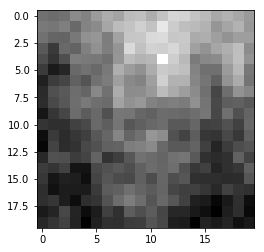

Cov Image: Non Face Component: 0


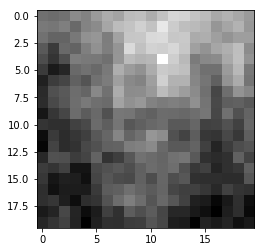

Mean Image: Non Face Component: 1


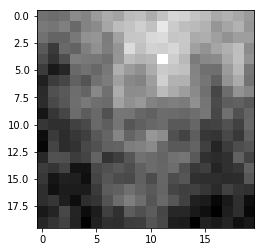

Cov Image: Non Face Component: 1


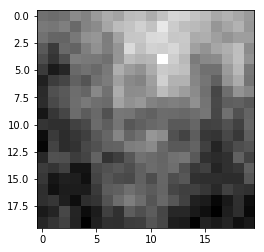

Mean Image: Non Face Component: 2


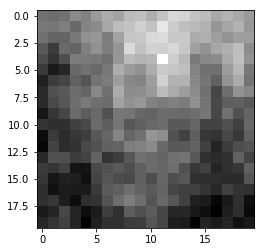

Cov Image: Non Face Component: 2


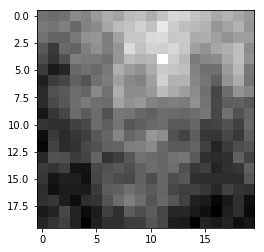

In [39]:
for k in range(no_of_components):
    mean_nf_image = np.dot(mean_nf[k][:,0], pca_nf.components_) + pca_nf.mean_
    mean_nf_image = mean_nf_image.reshape((20,20))
    
    cov_nf_image = np.dot(mog_nf.covs[k][:,0], pca_nf.components_) + pca_nf.mean_
    cov_nf_image = cov_nf_image.reshape((20,20))

    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Mean_Non_Face_Image_{}.jpg".format(k), mean_nf_image, cmap='gray')
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Cov_Non_Face_Image_{}.jpg".format(k), cov_nf_image, cmap='gray')
    
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Mean_Non_Face_Image_Resize_{}.jpg".format(k), \
                cv2.resize(mean_nf_image, (60,60)), cmap='gray')
    plt.imsave(dir_path + model_path + "Mixture_of_Gaussian/" + "Cov_Non_Face_Image_Resize_{}.jpg".format(k), \
                cv2.resize(cov_nf_image, (60,60)), cmap='gray')
    
    print("Mean Image: Non Face Component: {}".format(k))
    plt.imshow(mean_nf_image, cmap="gray")
    plt.show()
    
    print("Cov Image: Non Face Component: {}".format(k))
    plt.imshow(cov_nf_image, cmap="gray")
    plt.show()

In [18]:
pred_f_fdata, pred_f_nfdata, pred_nf_fdata, pred_nf_nfdata = [], [], [], []

for i in range(100):
    pred_f_fdata.append(mog_f.predict(te_f_data, i))
    pred_f_nfdata.append(mog_f.predict(te_nf_data, i))
    
    pred_nf_fdata.append(mog_nf.predict(te_f_data, i))
    pred_nf_nfdata.append(mog_nf.predict(te_nf_data, i))

pred_f_fdata = np.array(pred_f_fdata)
pred_f_nfdata = np.array(pred_f_nfdata)
pred_nf_fdata = np.array(pred_nf_fdata)
pred_nf_nfdata = np.array(pred_nf_nfdata)

pred_f_fdata = pred_f_fdata/(pred_f_fdata+pred_f_nfdata)
pred_f_nfdata = pred_f_nfdata/(pred_f_fdata+pred_f_nfdata)
pred_nf_fdata = pred_nf_fdata/(pred_nf_fdata+pred_nf_nfdata)
pred_nf_nfdata = pred_nf_nfdata/(pred_nf_fdata+pred_nf_nfdata)

In [19]:
pred_f_labels = [1 if pred_f_fdata[i]>pred_nf_fdata[i] else 0 for i in range(100)]
pred_nf_labels = [1 if pred_f_nfdata[i]>pred_nf_nfdata[i] else 0 for i in range(100)]

In [20]:
pred_labels = pred_f_labels + pred_nf_labels
true_labels = [1]*100 + [0]*100

In [21]:
def confusion_matrix(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [22]:
TP, FP, TN, FN = confusion_matrix(true_labels, pred_labels)

In [23]:
fpr =  FP/(FP+TN)
fnr = FN/(TP+FN)
mis_class_rate = (FP + FN)/200
print("False Positive Rate: {}".format(fpr))
print("False Negative Rate: {}".format(fnr))
print("Mis Classification Rate: {}".format(mis_class_rate))

False Positive Rate: 0.55
False Negative Rate: 0.4
Mis Classification Rate: 0.475


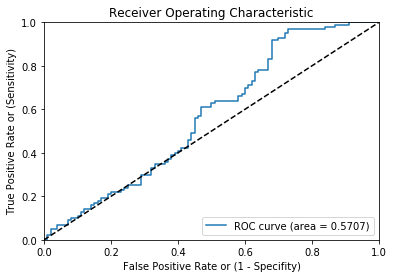

In [40]:
fpr, tpr, threshold = roc_curve(true_labels, np.append(pred_f_fdata, pred_nf_fdata))
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(dir_path + model_path + "Mixture_of_Gaussian/" + "Mixture_of_Gaussian_ROC_Curve.png")